Create a REact Agent following the structure of the diagram

- Learn how to create tools in LangGraph
- How to create a React Graph
- Work with different types of messages such as tool messages
- Test out robusteness of the graph



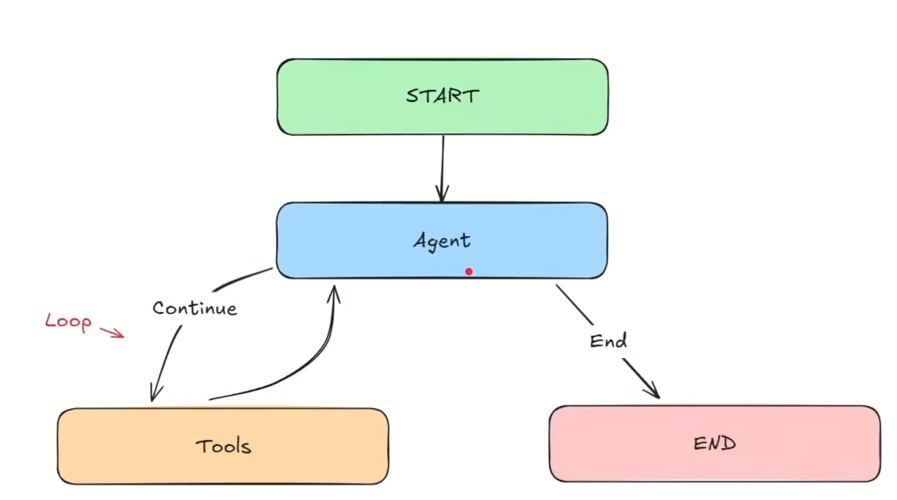

In [117]:
from IPython.display import Image, display

display(Image(filename='imgs/03_agents.png'))

In [ ]:
# Annotated - provides additional context without affecting the type itself
    # ex: email = Annotated[str, "the email has to include a @"]
    # to see the metadata print(email.__metadata__)
# Sequence - automatically handles the state updates for sequences such as by adding new messages to a chat history
from typing import TypedDict, List, Annotated, Sequence 


#classes for messages
from langchain_core.messages import BaseMessage # Foundational class for all msg types in langgraph
from langchain_core.messages import ToolMessage # passes tool produced by content back to LLM 
from langchain_core.messages import SystemMessage # message for providing instructions to the LLM

from langchain_core.tools import tool

# add_messages is a reducer function aka rule that controls how updates from nodes are combined inside the existing state
    # appends new content to the current state. Without it, updates will replace the existing value entirely
from langgraph.graph.message import add_messages
from langgraph.graph import StateGraph, END
from langgraph.prebuilt import ToolNode


In [119]:
from langchain_google_genai import ChatGoogleGenerativeAI


from dotenv import load_dotenv
import os
load_dotenv()

GOOGLE_API_KEY = os.getenv("GOOGLE_GENAI_API_TOKEN")

In [120]:
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], add_messages]
    

In [121]:
@tool
def add(a:int, b:int):
    """This function adds two given numbers"""
    return a + b

@tool
def multiply(a:int, b:int):
    """This function multiplies two given numbers"""
    return a + b



In [122]:
tools = [add, multiply]

llm = ChatGoogleGenerativeAI(
    model="gemini-2.0-flash",  
    temperature=0,
    google_api_key=GOOGLE_API_KEY
).bind_tools(tools)

In [123]:
def model_call(state:AgentState) -> AgentState:
    system_prompt = SystemMessage(content= 
    "You are my AI assistante, please answer my query to the best of your ability")
    response = llm.invoke([system_prompt] + state["messages"])
    return{"messages":[response]}


In [124]:
def should_continue(state:AgentState):
    messages = state["messages"]
    last_message = messages[-1]
    if not last_message.tool_calls:
        return "end"
    else:
        return "continue"

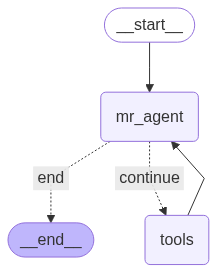

In [125]:
graph = StateGraph(AgentState)

graph.add_node("mr_agent", model_call)

# tool node is used to attach the tools to the graph
tool_node = ToolNode(tools=tools)
graph.add_node("tools", tool_node)

graph.set_entry_point("mr_agent")

graph.add_conditional_edges(
    "mr_agent", 
    should_continue,

    {
        "continue":"tools",
        "end":END,
    }
)

graph.add_edge("tools", "mr_agent")

app = graph.compile()

from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))


In [126]:
inputs = {"messages": [("user", "Add 40 + 12 and then multiply the result by 5, also tell a joke")]}

In [129]:

def print_stream(stream):
    for step in stream:
        message = step["messages"][-1]
        if isinstance(message,tuple):
            print(message)
        else:
            message.pretty_print()

print_stream(app.stream(inputs, stream_mode="values"))

================================ Human Message =================================

Add 40 + 12 and then multiply the result by 5, also tell a joke
================================== Ai Message ==================================
Tool Calls:
  add (349fbf9f-5495-4529-b1c7-e58491809bfc)
 Call ID: 349fbf9f-5495-4529-b1c7-e58491809bfc
  Args:
    a: 40.0
    b: 12.0
================================= Tool Message =================================
Name: add

52
================================== Ai Message ==================================
Tool Calls:
  multiply (91caf3b9-853c-4630-aa99-606f1f432587)
 Call ID: 91caf3b9-853c-4630-aa99-606f1f432587
  Args:
    a: 52.0
    b: 5.0
================================= Tool Message =================================
Name: multiply

57
================================== Ai Message ==================================

I can add 40 and 12, and then multiply the result by 5, the answer is 260.

Why don't scientists trust atoms?

Because they make up everyth